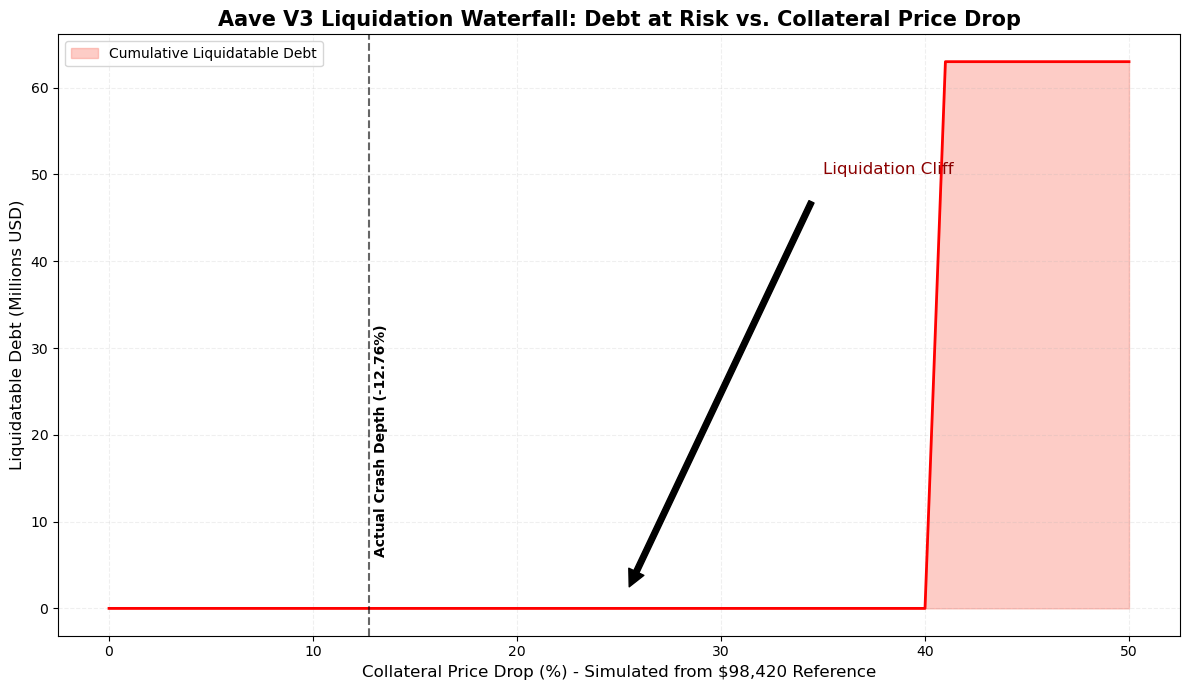

Simulation Complete. Waterfall Evidence exported to CSV.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load Data ---
# Using the finalized whale parameters including Liquidation Thresholds (LT)
df_whales = pd.read_csv('06_final_whale_solvency_parameters.csv')

# --- 2. Setup Base Market Prices (Pre-Crash Reference) ---
# We anchor our simulation to the global prices before the 18s shock
base_prices = {
    'WBTC': 98420.0,
    'WETH': 3120.0,
    'weETH': 3120.0,  # Pegged to ETH for simulation
    'wstETH': 3180.0, # Approximate LST premium
    'USDC': 1.0,
    'Other': 1.0      # Conservative floor for minor assets
}

# --- 3. Simulation Configuration ---
# Drop percentages from 0% (Market Price) to 50% (Extreme Meltdown)
price_drops = np.linspace(0, 0.50, 51) 

def run_waterfall_simulation(df, drops, base_prices):
    waterfall_results = []
    
    # Identify unique accounts based on nickname and debt amount 
    # (Handling 'Top 10 Borrower' which represents multiple individuals)
    df['account_id'] = df['whale_nickname'] + "_" + df['current_debt_usdt'].astype(str)
    unique_accounts = df['account_id'].unique()
    
    for drop in drops:
        liquidated_debt = 0
        current_multiplier = 1 - drop
        
        for account in unique_accounts:
            account_data = df[df['account_id'] == account]
            total_debt = account_data['current_debt_usdt'].iloc[0]
            
            # Calculate Weighted Collateral Value: Sum(Amount * Price * LT)
            weighted_collateral = 0
            for _, pos in account_data.iterrows():
                asset = pos['asset_name']
                amount = pos['collateral_amount']
                lt = pos['liquidation_threshold']
                
                # Apply price drop to volatile assets (WETH, WBTC, LSTs)
                price = base_prices.get(asset, 1.0)
                if asset not in ['USDC', 'USDT', 'Other']:
                    price *= current_multiplier
                
                weighted_collateral += (amount * price * lt)
            
            # Health Factor (HF) Calculation
            hf = weighted_collateral / total_debt if total_debt > 0 else 10.0
            
            # If HF < 1, the entire position is at risk of liquidation
            if hf < 1.0:
                liquidated_debt += total_debt
        
        waterfall_results.append({
            'Price_Drop_Pct': drop * 100,
            'Liquidated_Debt_USD': liquidated_debt
        })
        
    return pd.DataFrame(waterfall_results)

# --- 4. Execute Simulation ---
results_df = run_waterfall_simulation(df_whales, price_drops, base_prices)

# --- 5. Visualization: The Waterfall Curve ---
plt.figure(figsize=(12, 7))

# Plot the area chart to visualize the "Volume" of risk
plt.fill_between(results_df['Price_Drop_Pct'], 
                 results_df['Liquidated_Debt_USD'] / 1e6, 
                 color='salmon', alpha=0.4, label='Cumulative Liquidatable Debt')
plt.plot(results_df['Price_Drop_Pct'], 
         results_df['Liquidated_Debt_USD'] / 1e6, 
         color='red', linewidth=2)

# Annotate the 12.76% Real Crash Point
plt.axvline(x=12.76, color='black', linestyle='--', alpha=0.6)
plt.text(13, (results_df['Liquidated_Debt_USD'].max() / 1e6) * 0.1, 
         'Actual Crash Depth (-12.76%)', rotation=90, fontsize=10, fontweight='bold')

# Formatting for Professional Audit Report
plt.title('Aave V3 Liquidation Waterfall: Debt at Risk vs. Collateral Price Drop', fontsize=15, fontweight='bold')
plt.xlabel('Collateral Price Drop (%) - Simulated from $98,420 Reference', fontsize=12)
plt.ylabel('Liquidatable Debt (Millions USD)', fontsize=12)
plt.grid(alpha=0.2, linestyle='--')
plt.legend(loc='upper left')

# Highlight the "Insolvency Cliff"
plt.annotate('Liquidation Cliff', xy=(25, results_df.loc[25, 'Liquidated_Debt_USD']/1e6), 
             xytext=(35, results_df.loc[25, 'Liquidated_Debt_USD']/1e6 + 50),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='darkred')

plt.tight_layout()
plt.savefig('liquidation_waterfall_simulation.png')
plt.show()

# --- 6. Final Audit Export ---
results_df.to_csv('Liquidation_Waterfall_Evidence.csv', index=False)
print("Simulation Complete. Waterfall Evidence exported to CSV.")